In [1]:
!pip install transformer-lens==2.15.4
!pip install einops jaxtyping tqdm


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 6.0 MB/s eta 0:00:00
  Created wheel for transformers-stream-generator: filename=transformers_stream_generator-0.0.5-py3-none-any.whl size=12426 sha256=1339819fc2fb31a72028b03c2d9368514a1f435b09e78560f310786c1b8a3068
  Stored in directory: /root/.cache/pip/wheels/a8/58/d2/014cb67c3cc6def738c1b1635dbf4e3dab6fb63aba7070dce0
Successfully built transformers-stream-generator
  Attempting uninstall: beartype
    Found existing installation: beartype 0.22.6
    Uninstalling beartype-0.22.6:
      Successfully uninstalled beartype-0.22.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plum-dispatch 2.6.0 requires 

If you see this error => plum-dispatch 2.6.0 requires beartype>=0.16.2, but you have beartype 0.14.1 which is incompatible.
Then ignore it, the incompatibility doesnt impact us. Below imports should work flawlessly - any issue there an you need to contact me viraj@modelrecon.com

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

# Tiny transformer hyperparameters
class TinyConfig:
    vocab_size = 200
    seq_len = 64
    d_model = 128
    n_heads = 4
    n_layers = 2
    d_ff = 4 * d_model
    dropout = 0.0

cfg = TinyConfig()


In [3]:
def causal_mask(n, device):
    m = torch.triu(torch.ones(n, n, device=device), 1).bool()
    return m


Below is a very trivial transformer. I have added documentation also

In [4]:
# Tiny Transformer
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# -----------------------------------------------------
# Utility: Causal mask generator (auto-regressive mask) - just creates masks guys
# -----------------------------------------------------
def causal_mask(T, device):
    """
    Returns a boolean causal mask of shape (T, T),
    where mask[i, j] = True means position j is masked
    for query position i.
    """
    return torch.triu(torch.ones(T, T, device=device), diagonal=1).bool()


# -----------------------------------------------------
# Multi-Head Self Attention (Tiny version) - this is the core stuff
# -----------------------------------------------------
class TinyAttention(nn.Module):
    """
    Implements a minimal multi-head self-attention layer.

    Args:
        cfg: Configuration object containing:
            - d_model: total embedding dimension
            - n_heads: number of attention heads

    Shapes:
        Input:  (B, T, d_model)
        Output: (B, T, d_model), (B, h, T, T) attention scores
    """
    def __init__(self, cfg):
        super().__init__()
        d = cfg.d_model
        h = cfg.n_heads

        self.h = h                           # number of heads
        self.d_head = d // h                 # dimension per head

        # Linear projections for queries, keys, values
        self.Wq = nn.Linear(d, d, bias=False)
        self.Wk = nn.Linear(d, d, bias=False)
        self.Wv = nn.Linear(d, d, bias=False)

        # Output projection
        self.Wo = nn.Linear(d, d, bias=False)

    def forward(self, x, mask):
        """
        Performs multi-head self-attention with causal masking.

        Args:
            x: tensor of shape (B, T, D)
            mask: boolean mask broadcastable to (B, h, T, T)

        Returns:
            out: (B, T, D) attention result
            att: (B, h, T, T) softmaxed attention weights
        """
        B, T, D = x.shape
        h = self.h
        d = self.d_head

        # Project and reshape into heads: (B, h, T, d)
        q = self.Wq(x).view(B, T, h, d).transpose(1, 2)
        k = self.Wk(x).view(B, T, h, d).transpose(1, 2)
        v = self.Wv(x).view(B, T, h, d).transpose(1, 2)

        # Attention scores: (B, h, T, T)
        scores = (q @ k.transpose(-2, -1)) / math.sqrt(d)

        # Apply mask: masked positions get extremely negative score
        scores = scores.masked_fill(mask, -1e9)

        # Softmax over keys dimension
        att = F.softmax(scores, dim=-1)

        # Weighted sum of values
        out = att @ v

        # Recombine heads: (B, T, D)
        out = out.transpose(1, 2).contiguous().view(B, T, D)

        return self.Wo(out), att


# -----------------------------------------------------
# Feedforward Network - a simple FFN
# -----------------------------------------------------
class FF(nn.Module):
    """
    Standard Transformer feed-forward block:

        FF(x) = W2(GELU(W1(x)))

    Args:
        cfg (object): contains d_model and d_ff dimensions
    """
    def __init__(self, cfg):
        super().__init__()
        self.fc1 = nn.Linear(cfg.d_model, cfg.d_ff)
        self.fc2 = nn.Linear(cfg.d_ff, cfg.d_model)

    def forward(self, x):
        return self.fc2(F.gelu(self.fc1(x)))


# -----------------------------------------------------
# Transformer Block (LayerNorm → Attention → FFN)
# -----------------------------------------------------
class Block(nn.Module):
    """
    A single Transformer block containing:
        1. LayerNorm
        2. Multi-head attention
        3. Residual connection
        4. LayerNorm
        5. Feed-forward network
        6. Residual connection

    Args:
        cfg: config with d_model and n_heads
    """
    def __init__(self, cfg):
        super().__init__()
        self.ln1 = nn.LayerNorm(cfg.d_model)
        self.att = TinyAttention(cfg)
        self.ln2 = nn.LayerNorm(cfg.d_model)
        self.ff = FF(cfg)

    def forward(self, x, mask, acts, layer_id):
        """
        Args:
            x: (B, T, D)
            mask: causal mask
            acts: dict to store attention maps for analysis
            layer_id: integer layer index

        Returns:
            Updated x after passing through block
        """
        # ---- Self Attention sublayer ----
        h = self.ln1(x)
        att_out, att = self.att(h, mask)
        acts[f"layer{layer_id}.att"] = att.detach().cpu()
        x = x + att_out  # residual

        # ---- Feed-forward sublayer ----
        h = self.ln2(x)
        ff_out = self.ff(h)
        x = x + ff_out  # residual

        return x


# -----------------------------------------------------
# Full Tiny Transformer Model
# -----------------------------------------------------
class TinyTransformer(nn.Module):
    """
    Minimal Transformer language model.

    Components:
        - Token embedding
        - Positional embedding
        - N stacked Transformer blocks
        - Final LayerNorm
        - Linear unembedding to vocab

    Forward returns:
        logits of shape (B, T, vocab_size)
        optionally: attention activations
    """
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg

        # Embeddings
        self.tok = nn.Embedding(cfg.vocab_size, cfg.d_model)
        self.pos = nn.Embedding(cfg.seq_len, cfg.d_model)

        # Transformer layers
        self.blocks = nn.ModuleList([Block(cfg) for _ in range(cfg.n_layers)])

        # Final layer norm + output projection
        self.ln_f = nn.LayerNorm(cfg.d_model)
        self.unembed = nn.Linear(cfg.d_model, cfg.vocab_size, bias=False)

    def forward(self, x, return_acts=False):
        """
        Main forward pass.

        Args:
            x: token indices (B, T)
            return_acts: whether to return attention maps

        Returns:
            logits: (B, T, vocab_size)
            acts (optional): dict of attention activations
        """
        B, T = x.shape

        # Token + positional embeddings
        positions = torch.arange(T, device=x.device).unsqueeze(0)
        x = self.tok(x) + self.pos(positions)

        # Create broadcastable causal mask (1 x 1 x T x T)
        mask = causal_mask(T, x.device)[None, None, :, :]

        acts = {}
        for i, block in enumerate(self.blocks):
            x = block(x, mask, acts, i)

        # Final normalization + linear readout
        x = self.ln_f(x)
        logits = self.unembed(x)

        if return_acts:
            return logits, acts
        return logits


In [5]:
#data set

def make_repeating_dataset(n_samples, seq_len, vocab):
    data = []
    for _ in range(n_samples):
        base = torch.randint(5, 40, (1,)).item()
        seq = (torch.arange(base, base + seq_len) % vocab).clone()
        seq = (seq + torch.randint(0, 3, seq.shape)) % vocab
        data.append(seq)
    return torch.stack(data)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

data = make_repeating_dataset(5000, cfg.seq_len, cfg.vocab_size).to(device)


Using device: cuda


In [6]:
#training

model = TinyTransformer(cfg).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=3e-4)

steps = 600

for step in tqdm(range(steps)):
    batch = data[torch.randint(0, len(data), (32,))]   # B=32
    x = batch[:, :-1]
    y = batch[:, 1:]

    logits = model(x)
    loss = F.cross_entropy(logits.reshape(-1, cfg.vocab_size), y.reshape(-1))

    opt.zero_grad()
    loss.backward()
    opt.step()

    if step % 100 == 0:
        print("step:", step, "loss:", loss.item())

print("Training completed.")


  2%|▏         | 14/600 [00:00<00:26, 22.28it/s]

step: 0 loss: 5.443853378295898


 22%|██▏       | 130/600 [00:01<00:03, 131.63it/s]

step: 100 loss: 2.201927423477173


 36%|███▋      | 218/600 [00:02<00:02, 139.60it/s]

step: 200 loss: 1.656180500984192


 54%|█████▍    | 323/600 [00:03<00:02, 136.35it/s]

step: 300 loss: 1.4932799339294434


 71%|███████▏  | 428/600 [00:03<00:01, 140.63it/s]

step: 400 loss: 1.4067140817642212


 86%|████████▋ | 519/600 [00:04<00:00, 144.79it/s]

step: 500 loss: 1.3687539100646973


100%|██████████| 600/600 [00:05<00:00, 119.84it/s]

Training completed.


In [7]:
# sample one sequence
sample = data[:1, :-1]
logits, acts = model(sample, return_acts=True)

list(acts.keys())


['layer0.att', 'layer1.att']

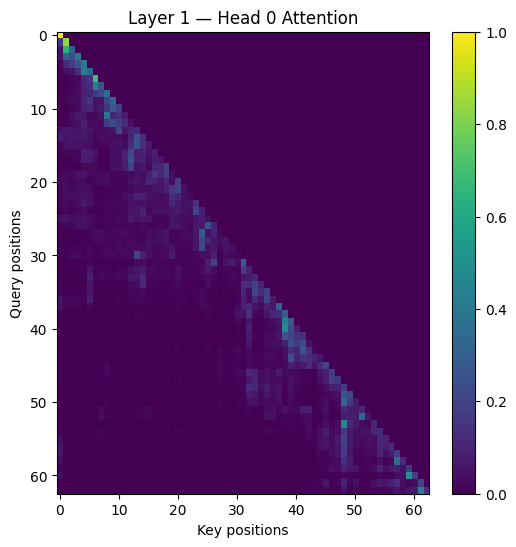

In [8]:
layer = 1
head = 0

att = acts[f"layer{layer}.att"][0, head].numpy()

plt.figure(figsize=(6,6))
plt.title(f"Layer {layer} — Head {head} Attention")
plt.imshow(att, aspect='auto')
plt.xlabel("Key positions")
plt.ylabel("Query positions")
plt.colorbar()
plt.show()
